### Análisis Univariado Numérico (chessData)
Este cuaderno se centra solo en *chessData.csv* y cubre un análisis exploratorio univariado básico:

1. Identificación de variables numéricas.
2. Estadísticos de centralidad, dispersión y forma.
3. Visualizaciones (Histograma + Medidas, Boxplot, Q-Q Plot).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# configuración del estilo
sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 110

DATA_DIR = Path('../data/raw')
CHESS_PATH = DATA_DIR / 'chessData.csv'

def load_chess(nrows=None, usecols=None):
    """Carga chessData.csv con backend pyarrow si disponible.
    - nrows: permite carga parcial para pruebas rápidas.
    - usecols: para limitar columnas.
    """
    read_kw = dict(low_memory=False, on_bad_lines='warn')
    try:
        # pandas >= 2 admite dtype_backend='pyarrow'
        return pd.read_csv(CHESS_PATH, dtype_backend='pyarrow', nrows=nrows, usecols=usecols, **read_kw)
    except TypeError:
        return pd.read_csv(CHESS_PATH, nrows=nrows, usecols=usecols, **read_kw)

df = load_chess()
print(f'Filas: {len(df):,}  | Columnas: {len(df.columns)}')
print('Columnas del df:', list(df.columns[:15]))

Filas: 12,958,035  | Columnas: 2
Columnas del df: ['FEN', 'Evaluation']


In [2]:
# conversion de columna evaluations, separa evaluaciones en centipawns y datos de mate

import re
import numpy as np

eval_col = "Evaluation"
print('Columnas :', eval_col)

# 2. Eliminar columnas antiguas *_num si existieran
old_num_cols = [c for c in eval_col if c.endswith('_num')]
if old_num_cols:
    print('Eliminando columnas previas *_num:', old_num_cols)
    df.drop(columns=[c for c in old_num_cols if c in df.columns], inplace=True, errors='ignore')

# 3. Reconstruir lista final de columnas de evaluación (sin *_num y que sigan existiendo)
eval_cols = [c for c in df.columns if re.search(r'(eval|score)', c, re.IGNORECASE) and not c.endswith('_num')]
print('Columnas de evaluación finales:', eval_cols)

if not eval_cols:
    print('\n No se detectaron columnas de evaluación después de la limpieza.')
    print('Algunas primeras columnas del DataFrame para inspección manual:')
    print(list(df.columns[:30]))
    subset_numeric = []
else:
    # 4. Patrones de mate: '#3', '#-5', 'M3', 'm4'
    mate_pat = re.compile(r'^[#M](-?\d+)$', re.IGNORECASE)

    def parse_eval_cell(x):
        """Devuelve (cp_value, mate_sign, mate_in)
        cp_value: float (centipawns) o NaN si es mate/no parseable
        mate_sign: 1 (mate a favor), -1 (mate en contra), 0 si no es mate
        mate_in: N jugadas hasta el mate (int) o NaN
        """
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return (np.nan, 0, np.nan)
        if isinstance(x, (int, float)):
            return (float(x), 0, np.nan)
        s = str(x).strip()
        if s == '' or s == '-':
            return (np.nan, 0, np.nan)
        s_norm = s.replace('+', '').replace(',', '.')
        m = mate_pat.match(s_norm)
        if m:
            moves = int(m.group(1))
            sign = 1
            if moves < 0:
                sign = -1
                moves = -moves
            return (np.nan, sign, moves)
        try:
            return (float(s_norm), 0, np.nan)
        except ValueError:
            return (np.nan, 0, np.nan)

    # 5. Aplicar a cada columna detectada
    created_cols = []
    for col in eval_cols:
        parsed = df[col].apply(parse_eval_cell)
        cp_col = col + '_cp'
        ms_col = col + '_mate_sign'
        mi_col = col + '_mate_in'
        df[cp_col] = parsed.map(lambda t: t[0])
        df[ms_col] = parsed.map(lambda t: t[1]).astype('Int8')
        df[mi_col] = parsed.map(lambda t: t[2]).astype('Int16')
        created_cols.extend([cp_col, ms_col, mi_col])

    print('Columnas creadas:', created_cols)

    # 6. Recalcular columnasde centipawns
    cp_cols = [c for c in df.columns if c.endswith('_cp')]
    print('Columnas de centipawns (cp_cols):', cp_cols)

    numeric_cols = cp_cols.copy()
    subset_numeric = cp_cols[:8]
    print('subset_numeric:', subset_numeric)

subset_numeric

Columnas : Evaluation
Columnas de evaluación finales: ['Evaluation']
Columnas creadas: ['Evaluation_cp', 'Evaluation_mate_sign', 'Evaluation_mate_in']
Columnas de centipawns (cp_cols): ['Evaluation_cp']
subset_numeric: ['Evaluation_cp']
Columnas creadas: ['Evaluation_cp', 'Evaluation_mate_sign', 'Evaluation_mate_in']
Columnas de centipawns (cp_cols): ['Evaluation_cp']
subset_numeric: ['Evaluation_cp']


['Evaluation_cp']

In [3]:
# Mostrar primeras 30 filas y luego 10 filas que tengan mate 

PRIMERAS = 30
MATE_MUESTRA = 10

print(f"Mostrando primeras {PRIMERAS} filas del DataFrame completo:\n")
display(df.head(PRIMERAS))

# Detectar todas las columnas *_mate_sign (puede haber más de una)
mate_cols = [c for c in df.columns if c.endswith('_mate_sign')]

# Inicializar la máscara (si no hay columnas quedará todo en False)
mate_mask = np.zeros(len(df), dtype=bool)

if not mate_cols:
    print('No se encontraron columnas de mate (_mate_sign).')
else:
    # Construir máscara: cualquier fila donde alguna columna *_mate_sign sea distinta de 0
    for mc in mate_cols:
        mate_mask |= df[mc].fillna(0) != 0

    mate_rows = df[mate_mask]
    total_mates = len(mate_rows)
    print(f"\nFilas con mate detectado: {total_mates}")

    if total_mates == 0:
        print('\nNo hay filas con mate para mostrar.')
    else:
        n_show = min(MATE_MUESTRA, total_mates)
        print(f"\nMostrando {n_show} filas con mate (head):\n")
        display(mate_rows.head(n_show))

        # Si quieres una muestra aleatoria distinta del head, descomenta:
        if total_mates > n_show:
            print(f"\nMuestra aleatoria de {n_show} filas con mate:")
            display(mate_rows.sample(n=n_show, random_state=42))

# (Opcional) Mostrar solo columnas relevantes para mate (descomenta si lo prefieres)
mate_cols_preview = [c for c in df.columns if c.endswith(('_mate_sign','_mate_in','_cp'))]
display(df.loc[mate_mask, mate_cols_preview].head(MATE_MUESTRA))

Mostrando primeras 30 filas del DataFrame completo:



,FEN,Evaluation,Evaluation_cp,Evaluation_mate_sign,Evaluation_mate_in
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10,-10.0,0,<NA>
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56,56.0,0,<NA>
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9,-9.0,0,<NA>
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52,52.0,0,<NA>
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26,-26.0,0,<NA>
5,rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQ...,+50,50.0,0,<NA>
6,rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQ...,+10,10.0,0,<NA>
7,rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQ...,+75,75.0,0,<NA>
8,rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1B...,+52,52.0,0,<NA>
9,rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1...,+52,52.0,0,<NA>



Filas con mate detectado: 190154

Mostrando 10 filas con mate (head):



,FEN,Evaluation,Evaluation_cp,Evaluation_mate_sign,Evaluation_mate_in
59,7k/p1r2b2/4pq2/1p1p1nR1/5P2/P2B4/1P2Q2P/1K4R1 ...,#+6,NaN,1,6
60,7k/p1r2b2/4pq2/1p1p1BR1/5P2/P7/1P2Q2P/1K4R1 b ...,#+6,NaN,1,6
61,7k/p1r2b2/5q2/1p1p1pR1/5P2/P7/1P2Q2P/1K4R1 w -...,#+4,NaN,1,4
62,7k/p1r2b2/5q2/1p1p1p1R/5P2/P7/1P2Q2P/1K4R1 b -...,#+3,NaN,1,3
1440,7Q/8/4k3/p1p2p2/P7/1Pp1q1K1/6P1/8 w - - 3 64,#-19,NaN,-1,19
1989,3r3k/p4Q2/3bp2p/2ppqp2/8/P1P3RP/1P3PP1/3R2K1 w...,#+5,NaN,1,5
1990,3r3k/p4Q2/3bp1Rp/2ppqp2/8/P1P4P/1P3PP1/3R2K1 b...,#+4,NaN,1,4
2561,6k1/p4p2/2b3pQ/5q2/2p5/P1P3R1/4r1PP/3Rn1K1 b -...,#-2,NaN,-1,2
2562,6k1/p4p2/2b3pQ/8/2p5/P1P3R1/4rqPP/3Rn1K1 w - -...,#-1,NaN,-1,1
3311,3q3r/5R2/7k/1b1pPp1p/p2P4/Q7/6PP/1r2BRK1 w - -...,#+8,NaN,1,8



Muestra aleatoria de 10 filas con mate:


,FEN,Evaluation,Evaluation_cp,Evaluation_mate_sign,Evaluation_mate_in
6882481,6k1/1R6/3qpQp1/7p/8/3n1BP1/1P3r1P/6K1 b - - 1 37,#+5,NaN,1,5
12446460,8/p6k/1p1p3p/2pNbnp1/2P5/3P3q/PP5P/2BQ3K w - -...,#-10,NaN,-1,10
12945063,6k1/6pp/1p2P3/3p1p2/3P1P2/1p4PP/2r5/6K1 w - - ...,#-4,NaN,-1,4
8986868,r1b1r1k1/ppb2pp1/5n1p/PB1p4/NP1p4/3P1P1P/2PB2P...,#-1,NaN,-1,1
5516562,5r2/RR5k/4p1pn/2pb2N1/8/2P5/1P3PP1/6K1 b - - 1 35,#+3,NaN,1,3
4435691,3k4/5Rp1/2PNpp1p/3p4/3Pb2P/6P1/6r1/5K2 b - - 3 49,#+3,NaN,1,3
10195506,8/1pp2ppk/p2P3p/8/1P6/PKN5/5q2/4rb2 b - - 3 36,#-4,NaN,-1,4
8745613,2k4r/1pp5/1pnpp3/4p3/1PP1P3/P2P1q1r/R6R/2B3QK ...,#-6,NaN,-1,6
2055524,1n1Q2k1/6bp/3pN1p1/3Pp3/1P6/1q6/5PPP/2Br1RK1 b...,#+1,NaN,1,1
10013528,Q7/8/8/4p3/5k2/5P2/2pK4/8 b - - 0 58,#+12,NaN,1,12


,Evaluation_cp,Evaluation_mate_sign,Evaluation_mate_in
59,NaN,1,6
60,NaN,1,6
61,NaN,1,4
62,NaN,1,3
1440,NaN,-1,19
1989,NaN,1,5
1990,NaN,1,4
2561,NaN,-1,2
2562,NaN,-1,1
3311,NaN,1,8


In [ ]:
# Calculamos media, mediana, moda, desviación estándar, varianza, IQR, MAD, rango, coeficiente de variación, asimetría y curtosis.

def summarize_numeric(df, columns):
    rows = []
    for col in columns:
        s = df[col].dropna()
        if s.empty:
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        try:
            mode_val = s.mode().iloc[0]
        except Exception:
            mode_val = np.nan
        mad = stats.median_abs_deviation(s, nan_policy='omit') if len(s) > 1 else 0.0
        rows.append({
            'col': col,
            'count': int(s.count()),
            'mean': s.mean(),
            'median': s.median(),
            'mode': mode_val,
            'std': s.std(),
            'var': s.var(),
            'min': s.min(),
            'q1': q1,
            'q3': q3,
            'max': s.max(),
            'iqr': iqr,
            'mad': mad,
            'cv': (s.std()/s.mean()) if s.mean() not in (0, np.nan) else np.nan,
            'skew': s.skew(),
            'kurtosis': s.kurtosis(),
            'missing': df[col].isna().sum(),
            'missing_pct': df[col].isna().mean()*100
        })
    out = pd.DataFrame(rows)
    return out.set_index('col').round(4)

summary_table = summarize_numeric(df, subset_numeric)
summary_table

,count,mean,median,mode,std,var,min,q1,q3,max,iqr,mad,cv,skew,kurtosis,missing,missing_pct
col,,,,,,,,,,,,,,,,,
Evaluation_cp,12767881,45.5066,15.0,0.0,813.8864,662411.1332,-15312.0,-71.0,144.0,15319.0,215.0,108.0,17.885,0.3316,40.9723,190154,1.4675


In [ ]:
# Funcion para analisis univariado con histograma, boxplot y q-q plot

def univariate_plot(df, column, target=None, bins=50):
    if column not in df.columns:
        raise ValueError(f'Columna {column} no existe')
    s = df[column].dropna()
    fig, axes = plt.subplots(2, 2, figsize=(13, 9))
    fig.suptitle(f'Análisis Univariado: {column}', fontsize=14, fontweight='bold')

    # 1 Histograma
    ax = axes[0,0]
    ax.hist(s, bins=bins, edgecolor='black', alpha=0.7)
    ax.axvline(s.mean(), color='red', linestyle='--', label=f'Media {s.mean():.2f}')
    ax.axvline(s.median(), color='green', linestyle='--', label=f'Mediana {s.median():.2f}')
    ax.set_title('Histograma')
    ax.legend()

    # 2 Boxplot
    ax = axes[0,1]
    bp = ax.boxplot(s, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = s[(s < q1 - 1.5*iqr) | (s > q3 + 1.5*iqr)]
    ax.set_title(f'Boxplot (outliers: {len(outliers)})')

    # 3 Q-Q Plot
    ax = axes[1,0]
    stats.probplot(s, dist='norm', plot=ax)
    ax.set_title('Q-Q Plot')

    # 4 Panel target o stats
    ax = axes[1,1]
    if target and target in df.columns and df[target].dtype.kind in 'if':
        x = df[column]
        y = df[target]
        valid = x.notna() & y.notna()
        ax.scatter(x[valid], y[valid], s=10, alpha=0.4)
        ax.set_xlabel(column)
        ax.set_ylabel(target)
        try:
            z = np.polyfit(x[valid], y[valid], 1)
            p = np.poly1d(z)
            order = np.argsort(x[valid])
            ax.plot(x[valid].iloc[order], p(x[valid].iloc[order]), 'r--', lw=2)
        except Exception:
            pass
        corr = x.corr(y)
        ax.text(0.05, 0.95, f'Correlación: {corr:.3f}', transform=ax.transAxes,
                va='top', bbox=dict(boxstyle='round', facecolor='wheat'))
        ax.set_title(f'{column} vs {target}')
    else:
        stats_text = [
            f'Count: {s.count()}',
            f'Mean: {s.mean():.2f}',
            f'Median: {s.median():.2f}',
            f'Mode: {s.mode().iloc[0] if not s.mode().empty else "N/A"}',
            f'Std: {s.std():.2f}',
            f'IQR: {(s.quantile(0.75) - s.quantile(0.25)):.2f}',
            f'Skew: {s.skew():.2f}',
            f'Kurtosis: {s.kurtosis():.2f}'
        ]
        ax.axis('off')
        ax.text(0, 1, '\n'.join(stats_text), va='top', ha='left', fontsize=12, family='monospace')
        ax.set_title('Estadísticas')

In [ ]:

cols_eval = subset_numeric[:3]
cols_eval

['Evaluation_cp']

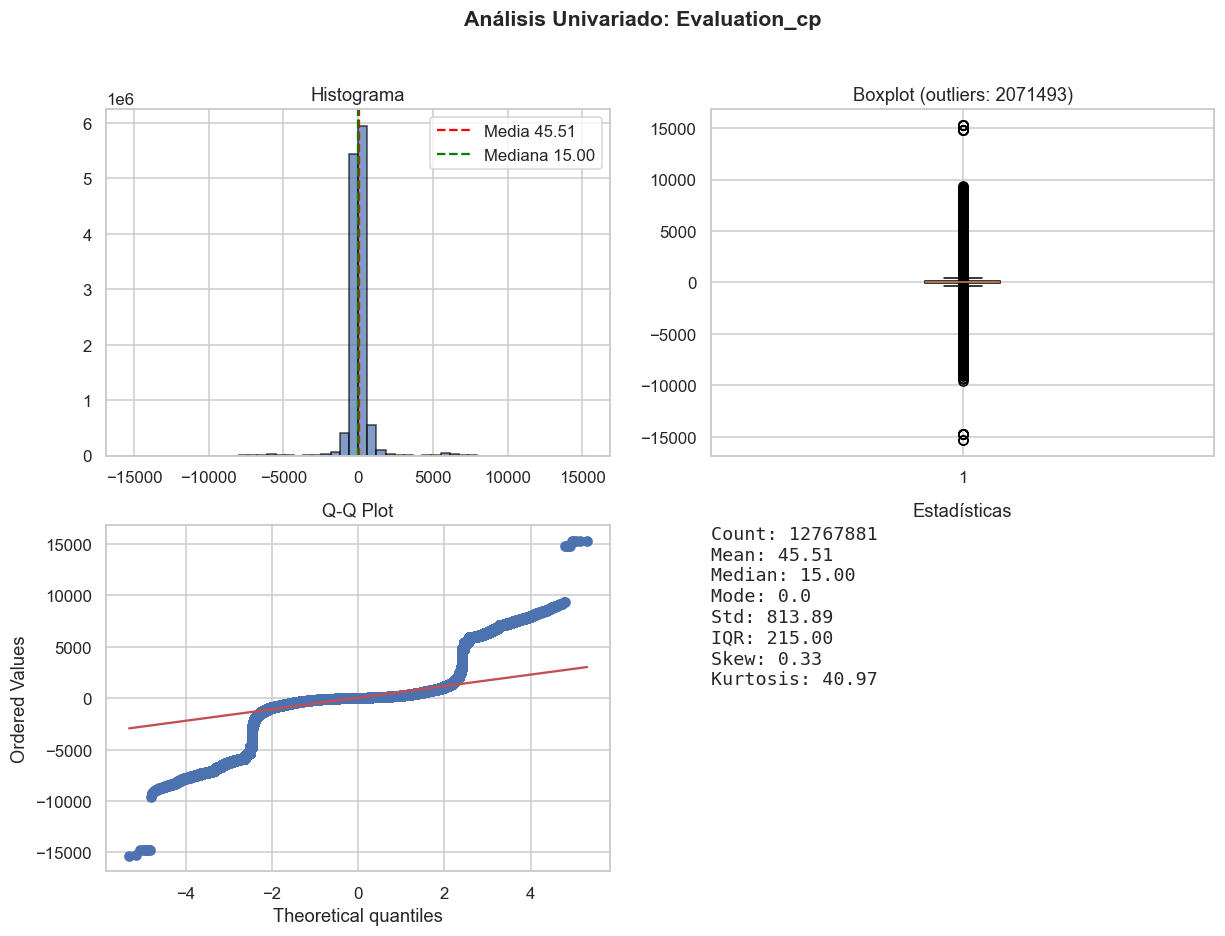

In [7]:
for c in cols_eval:
    univariate_plot(df, c)

In [8]:
col = "Evaluation_cp"
series = df[col].dropna()

q1, q3 = series.quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr

mask_low = series < low
mask_high = series > high

summary = {
    "n_total": len(series),
    "q1": q1,
    "q3": q3,
    "iqr": iqr,
    "lower_fence": low,
    "upper_fence": high,
    "n_low_outliers": mask_low.sum(),
    "n_high_outliers": mask_high.sum(),
    "pct_outliers": (mask_low.sum() + mask_high.sum()) / len(series) * 100
}
summary

{'n_total': 12767881,
 'q1': -71.0,
 'q3': 144.0,
 'iqr': 215.0,
 'lower_fence': -393.5,
 'upper_fence': 466.5,
 'n_low_outliers': np.int64(973866),
 'n_high_outliers': np.int64(1097627),
 'pct_outliers': np.float64(16.22425052363818)}